In [5]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as sp
import os

import statsmodels


In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Kurs walut

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


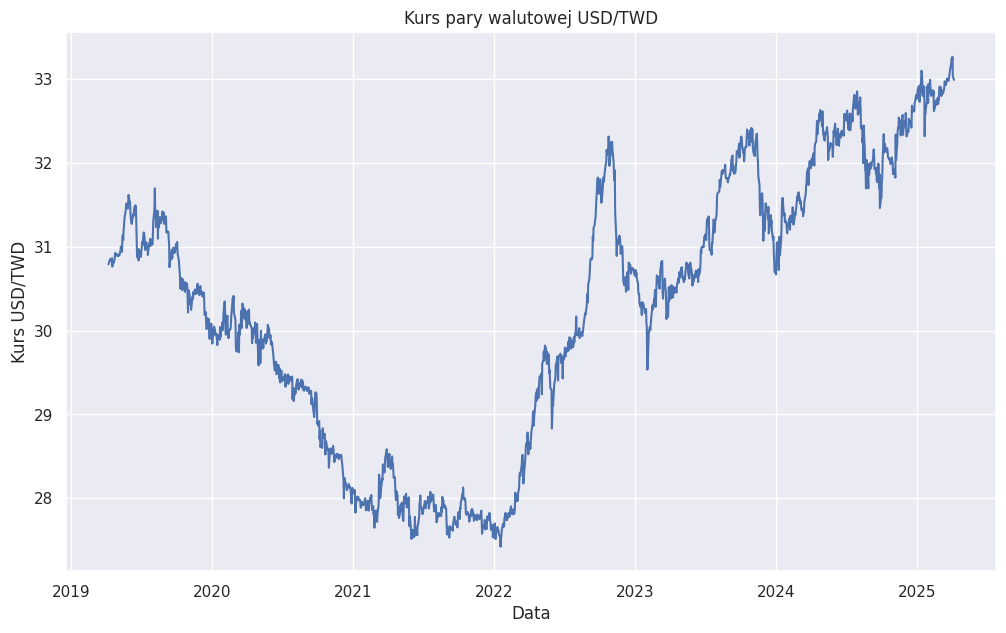

In [3]:
usd_twd = yf.download('USDTWD=X', period='6y')['Close']

plt.plot(usd_twd)
plt.title('Kurs pary walutowej USD/TWD')
plt.ylabel('Kurs USD/TWD')
plt.xlabel('Data')
plt.grid(True)
plt.show()

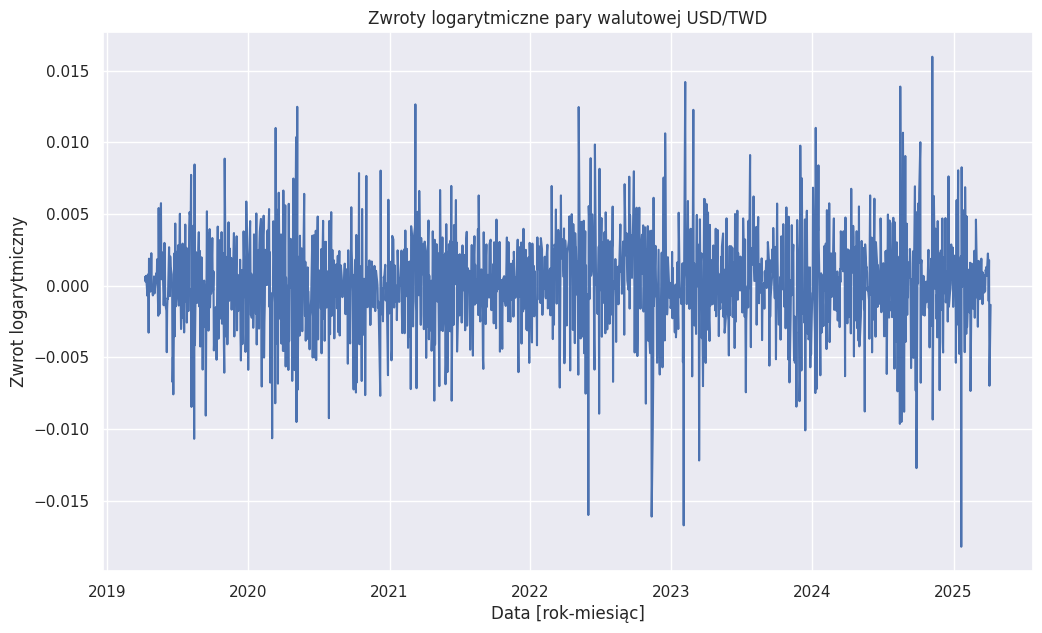

In [8]:
log_returns_usd_twd = np.log(usd_twd / usd_twd.shift(1)).dropna()

plt.plot(log_returns_usd_twd)
plt.title('Zwroty logarytmiczne pary walutowej USD/TWD')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

# Rozkład maksimum, podejście pierwsze

a L przyjmuje dodatnie zwroty logarytmiczne R. Maksimum jest liczone dla step = 10, a rozkład jest dopasowywane metodą największej wiarygodności, wybieram 1800 ostatnich obserwacji

In [32]:
X_usd_twd = []

for x in np.ravel(log_returns_usd_twd):
    if (x > 0):
        X_usd_twd.append(x)

X_usd_twd

[np.float64(0.0006169458786987775),
 np.float64(0.0002920526057144173),
 np.float64(0.0006812070286306752),
 np.float64(0.00045388035392573766),
 np.float64(0.0007781651336434056),
 np.float64(0.0002916790551017719),
 np.float64(0.0018836862340277588),
 np.float64(0.0010706425143263711),
 np.float64(0.0004538509141813958),
 np.float64(0.002266169993189717),
 np.float64(0.0006473268885951396),
 np.float64(0.00016188615808078146),
 np.float64(0.0004853778778044514),
 np.float64(0.0008731362526284805),
 np.float64(0.0002585378693164856),
 np.float64(0.0018403192895785454),
 np.float64(0.005415675790128437),
 np.float64(0.0010924876419772045),
 np.float64(0.003469157696499794),
 np.float64(0.005755176317992793),
 np.float64(0.0004462416586888801),
 np.float64(0.002323619406109092),
 np.float64(0.001937549636308028),
 np.float64(0.0029841853898256933),
 np.float64(0.0021847715947849594),
 np.float64(0.0026826674574908557),
 np.float64(0.0010200698407451863),
 np.float64(0.002038515599772492

In [34]:
n = 1800
step = 10

# wybieram 1800 punktów (ostatnich, dodatnich logarytmicznych stóp zwrotu)
usd_twd_1800 = X_usd_twd[-n:]
usd_twd_1800


[np.float64(0.0006169458786987775),
 np.float64(0.0002920526057144173),
 np.float64(0.0006812070286306752),
 np.float64(0.00045388035392573766),
 np.float64(0.0007781651336434056),
 np.float64(0.0002916790551017719),
 np.float64(0.0018836862340277588),
 np.float64(0.0010706425143263711),
 np.float64(0.0004538509141813958),
 np.float64(0.002266169993189717),
 np.float64(0.0006473268885951396),
 np.float64(0.00016188615808078146),
 np.float64(0.0004853778778044514),
 np.float64(0.0008731362526284805),
 np.float64(0.0002585378693164856),
 np.float64(0.0018403192895785454),
 np.float64(0.005415675790128437),
 np.float64(0.0010924876419772045),
 np.float64(0.003469157696499794),
 np.float64(0.005755176317992793),
 np.float64(0.0004462416586888801),
 np.float64(0.002323619406109092),
 np.float64(0.001937549636308028),
 np.float64(0.0029841853898256933),
 np.float64(0.0021847715947849594),
 np.float64(0.0026826674574908557),
 np.float64(0.0010200698407451863),
 np.float64(0.002038515599772492

In [35]:
M_usd_twd = []
step = 10
i = step
while i < len(usd_twd_1800) + 1:
    usd_twd_1800.append(max(usd_twd_1800[i-step:i]))
    i += step
print(len(usd_twd_1800))

ksi_usd_twd, mu_usd_twd, sigma_usd_twd = sp.genextreme.fit(usd_twd_1800)

885


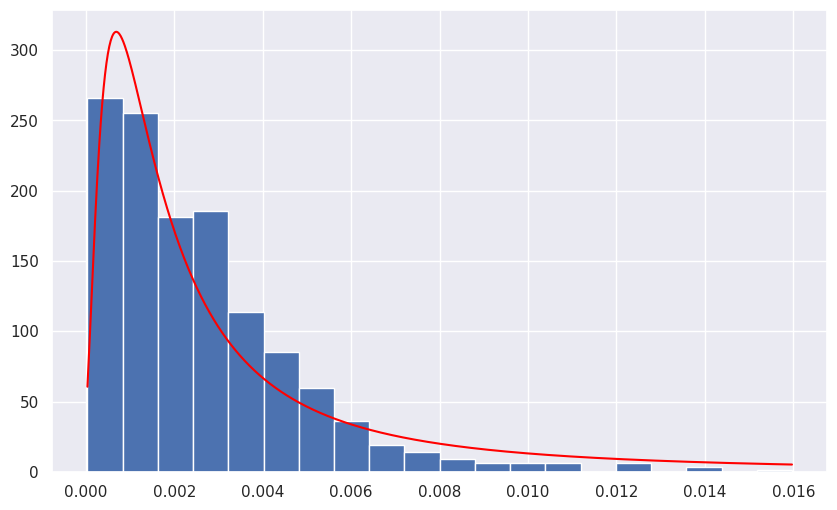

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(X_usd_twd, bins=20, density=True)
xs = np.linspace(min(X_usd_twd), max(X_usd_twd), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi_usd_twd, mu_usd_twd, sigma_usd_twd), c='red')
plt.show()

In [37]:
print("ksi: ", ksi_usd_twd, "\nmu: " , mu_usd_twd, "\nsigma: ", sigma_usd_twd)

ksi:  -0.8630521132082922 
mu:  0.0014454090277063372 
sigma:  0.001580662732885331
